# NCDHAS Pipeline Walkthrough

This notebook walks through how to run Karl Misselt's NCDHAS pipeline and reduce CV3 data.  

## Environment Setup

NCDHAS ramps-to-slopes pipeline is installed on the JWST witserv, so you must remotely login to the server via SSH to access the pipeline. We currently have version 107. Karl said he has a version 108 for OTIS testing, but this version was not given to us. To install the newer version onto witserv, we have to submit a ticket through ITSD after Karl sends us his new version.

First, log in to witserv:
    
        % ssh -XY username@witserv<#>.stsci.edu
    
        Where <#> is 1, 2, or 3 and username is your AD username.
    
From witserv, you can set the environment variables to access NCDHAS. However, I prefer to run it from within my JWST pipeline environment so I can compare the results. Once you are in your preferred server environment, set the environment variables:

        Under csh, tcsh:
        % setenv NCDHAS_PATH /grp/software/Linux/RH6/x86_64/ncdhas
        % setenv PATH ${NCDHAS_PATH}:${PATH}
 
        Under bash:
        % export NCDHAS_PATH=/grp/software/Linux/RH6/x86_64/ncdhas
        % export PATH=$PATH:$NCDHAS_PATH
    
** To run the pipeline in this notebook, you must open the notebook from within your NCDHAS pipeline environment! "shift+enter" is the hot key to run a cell of the notebook. **   

## Import modules and functions

In [1]:
# Import Plotting and Analysis Modules
from IPython.display import Image, display
import os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import itertools
import numpy as np 
%matplotlib inline



# define some functions for easier plotting and analysis

# display image

def display_img(image, vmin, vmax):
    plt.figure(figsize=(20,20))
    plt.ylabel('y pixels',fontsize=22)
    plt.xlabel('x pixels',fontsize=22)
    plt.imshow(image, vmin = vmin, vmax=vmax, cmap=plt.cm.gray, origin='lower')
    plt.colorbar(orientation='horizontal',pad=0.05) 
    return plt


# define function for easier plotting of pixels

def plot_pixel(image, xpix, ypix, label, ax, color, ymin, ymax, xmin, xmax,mode):
    nframe = readpatts[mode.lower()]['nframe']
    nskip = readpatts[mode.lower()]['nskip']
    ngroup = readpatts[mode.lower()]['ngroup']
    tgroup = readpatts[mode.lower()]['tgroup']
    dataloc = (nframe+nskip)/2
    ax.plot(np.arange(dataloc,len(image)*(nframe+nskip)+dataloc,(nframe+nskip))*10.73676, image[:,ypix,xpix], label=label, marker='d',markersize=10, color=color)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin-tgroup,xmax*tgroup+tgroup)
    ax.legend(loc='best')
    return ax



# find saturated pixel by looking for pixel w/ signal level higher than some threshold (DN)
# e.g. jj,ii = find_sat_pix(image,60000)

def find_sat_pix(data,threshold):
    saturated = np.where(data > threshold)
    ii = saturated[2][0]
    jj = saturated[1][0]
    return jj, ii


# find cosmic rays by looking for pixels w/ signal differences higher given threshold (integer)
# e.g. nn,mm = find_cr_pix(image,5)

def find_cr_pix(data,threshold):
    coords = []
    readnoise = 16
    #loop over pixel coordinate combinations 
    # full array would be (0,2048)
    for i,j in itertools.product(np.arange(300,800), np.arange(300,800)):
        y = data[:,j,i]
        # this method is a simplified version of what the pipeline does
        ydiff = np.abs(np.diff(y))
        poisson_noise = np.sqrt(np.abs(ydiff))
        yerr_exp = np.sqrt(poisson_noise*poisson_noise + readnoise*readnoise)
        ratio = ydiff/yerr_exp
        candidate = ratio.argmax()
        if ratio[candidate] > threshold:
            coords.append([j,i])
        sample = random.sample(coords, 1)
    return sample[0][1],sample[0][0]


# find bad pixels by loading the appropriate bad pixel mask and choosing a pixel flagged as "bad"
# e.g. kk,ll = find_bad_pix("NRCA1_17004_BPM_ISIMCV3_2016-01-21_ssbspmask_DMSorient.fits")

def find_bad_pix(bpm):
    # bpm is the bad pixel mask that will be used for calibration of the file
    badpix = np.where(bpm == 5)
    mm = badpix[1][0]
    nn = badpix[0][1]
    return nn,mm


# NIRCam readmode dictionary for ramp values

deep8 = {}
deep8['tgroup'] = 212.
deep8['ngroup'] = 20.
deep8['nframe'] = 8
deep8['nskip'] = 12

deep2 = {}
deep2['tgroup'] = 212.
deep2['ngroup'] = 20.
deep2['nframe'] = 2
deep2['nskip'] = 18

medium8 = {}
medium8['tgroup'] = 106.
medium8['ngroup'] = 10.
medium8['nframe'] = 8
medium8['nskip'] = 2

medium2 = {}
medium2['tgroup'] = 106.
medium2['ngroup'] = 10.
medium2['nframe'] = 2
medium2['nskip'] = 8

shallow4 = {}
shallow4['tgroup'] = 53.
shallow4['ngroup'] = 10.
shallow4['nframe'] = 4
shallow4['nskip'] = 1

shallow2 = {}
shallow2['tgroup'] = 53.
shallow2['ngroup'] = 10.
shallow2['nframe'] = 2
shallow2['nskip'] = 3

bright2 = {}
bright2['tgroup'] = 21.2
bright2['ngroup'] = 10.
bright2['nframe'] = 2
bright2['nskip'] = 0

bright1 = {}
bright1['tgroup'] = 21.2
bright1['ngroup'] = 10.
bright1['nframe'] = 1
bright1['nskip'] = 1

rapid = {}
rapid['tgroup'] = 10.73676
rapid['ngroup'] = 10.
rapid['nframe'] = 1
rapid['nskip'] = 0

readpatts = {}
readpatts['deep8'] = deep8
readpatts['deep2'] = deep2
readpatts['medium8'] = medium8
readpatts['medium2'] = medium2
readpatts['shallow4'] = shallow4
readpatts['shallow2'] = shallow2
readpatts['bright2'] = bright2
readpatts['bright1'] = bright1
readpatts['rapid'] = rapid

## Check data formats

The NCDHAS pipeline requires data to be in **FITSWriter format**. The test data should already be in this format. 

** FITSWriter format (science data in the PRIMARY extension)**:

        In [6]: from astropy.io import fits
        In [7]: fits.info("NRCV82600049001P0000000002102.fits")
        Filename: NRCV82600049001P0000000002102.fits
        No.    Name         Type      Cards   Dimensions   Format
            0  PRIMARY     PrimaryHDU     381   (320, 320, 20) int16 (rescales to uint16)  
            1  ENG         BinTableHDU     15   78148R x 3C  [30A, 30A, 30A

**SSB format (science data in the SCI extension)**:

        In [1]: from astropy.io import fits 
        In [2]: fits.info("NRCNRCA1-DARK-60012216201_uncal.fits")
        Filename: NRCNRCA1-DARK-60012216201_uncal.fits
        No.    Name         Type      Cards   Dimensions   Format
              0  PRIMARY     PrimaryHDU     392   ()     
              1  SCI         ImageHDU        10   (2048, 2048, 108, 1)   float32  
              2  PIXELDQ     ImageHDU        10   (2048, 2048) int32 (rescales to uint32)  
              3  GROUPDQ     ImageHDU        10   (2048, 2048, 108, 1)   uint8  
              4  ERR         ImageHDU        10   (2048, 2048, 108, 1)   float32  
              5  ASDF        ImageHDU         7   (1811965775,)   uint8

## Load and check the raw data file

Filename: NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     381   (320, 320, 20)   int16 (rescales to uint16)   
  1  ENG         BinTableHDU     15   78148R x 3C   [30A, 30A, 30A]   


<module 'matplotlib.pyplot' from '/Users/acanipe/miniconda2/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

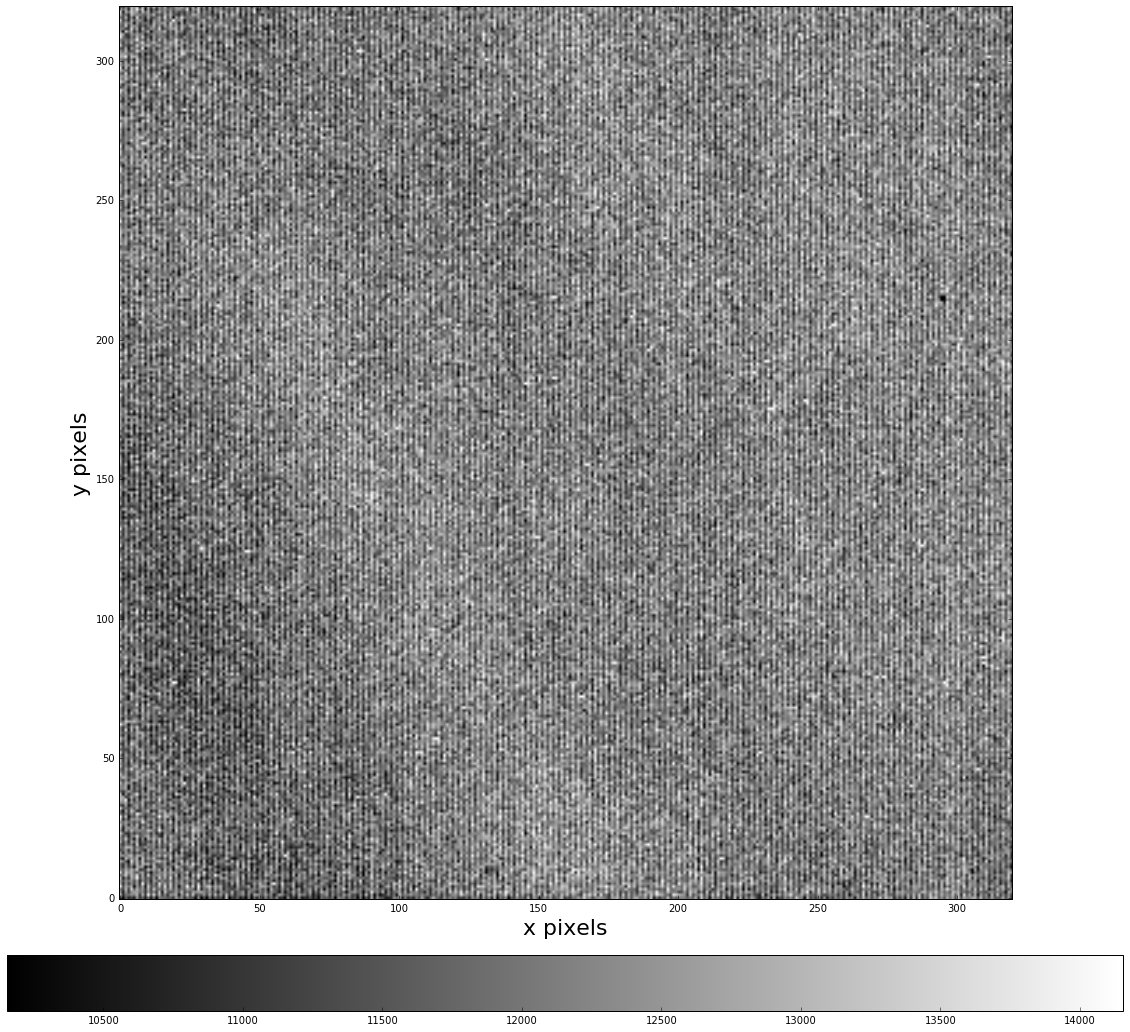

In [2]:
uncalFile = "NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.fits"
fileBase = uncalFile[:-5]

# use astropy to access the data
with fits.open(uncalFile) as h:
    h.info()
    imageUncal = h[0].data
    ngroups = np.shape(imageUncal)[0]
    mode = 'RAPID'
    
# display the first group of the image 
# vmin/vmax match ds9 scale limits or the limits of the data
# use sigma_clipped_stats to get mean for image limits
mean,med,std = sigma_clipped_stats(imageUncal[0,:,:],sigma=3)
display_img(imageUncal[0,:,:],mean-2000,mean+2000)

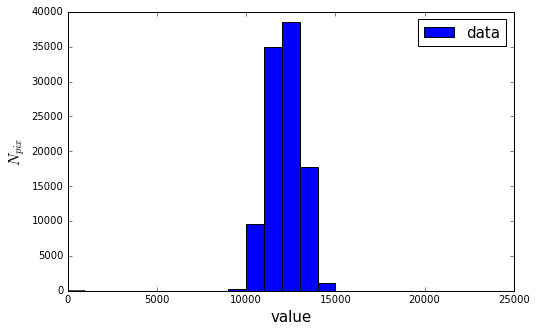

In [3]:
# make a histogram of the values in the first group
plt.figure(figsize=(8, 5))
bin_vals,bins,patches = plt.hist(np.ravel(imageUncal[0,:,:]),bins=np.arange(0,mean+10000,1000),range=(0,mean+10000),label='data')
plt.xlabel('value',fontsize=15)
plt.ylabel('$N_{pix}$',fontsize=15)
plt.legend(fontsize=15)

## Choose pixels to study throughout calibration steps

In [4]:
# look at weird pixels: peak of PSF (saturated), CRs, hot pixels, etc.
# ** note that python coords start from 0,0 and there is a 4 pixel wide border of reference pixels around the detector **

repx =  105       # random pix x
repy = 102        # random pix y

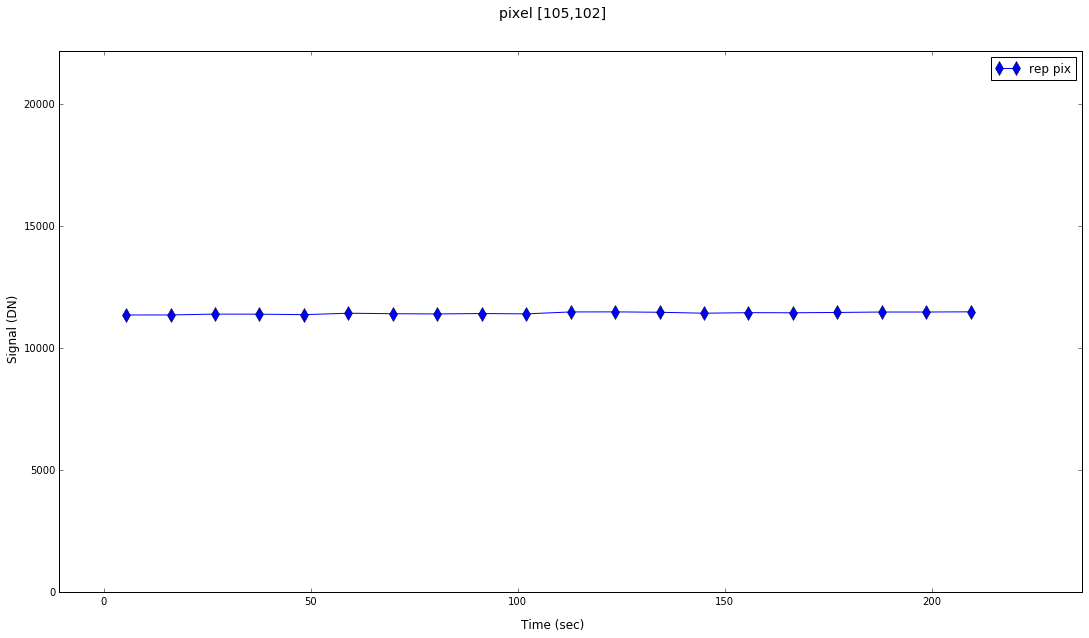

In [5]:
# plot uncalibrated ramp

f, ax = plt.subplots(1, 1, figsize=(15,8))
ax = plot_pixel(imageUncal, repx, repy,'rep pix',ax, 'blue',0,mean+10000, 0,ngroups+1, mode)
f.text(0.5, -0.02, 'Time (sec)', ha='center', fontsize=12)
f.text(0.5, 1.04, 'pixel [%s,%s]'% (str(repx),str(repy)), ha='center', fontsize=14)
f.text(-0.005, 0.5, 'Signal (DN)', va='center', rotation='vertical', fontsize=12)
f.tight_layout()

In [6]:
# check baseline values for data

print('\nFor representative pixel:')
print('IMAGE:',imageUncal[:,repy,repx])


For representative pixel:
IMAGE: [11356 11357 11392 11389 11369 11428 11408 11398 11415 11401 11480 11483
 11467 11428 11451 11446 11459 11477 11477 11485]


## On to calibration

## Notes about running NCDHAS pipeline

The NCDHAS pipeline automatically runs the full ramps-to-slopes calibration steps, which include:
        
        data quality initialization
        IPC correction
        reference correction
        detect saturation
        dark correction
        linearity correction
        detect CRs
        slope fitting
        flat field

The outputs of the NCDHAS pipeline are:
        
        calibrated file (*.red.fits)
        slope image (*.slp.fits) 
        diagnostic file (*.dia.fits)  
        
It doesn't allow an easy way to run intermediate steps alone, or output intermediate step results. In order to do that, you must turn off the steps you don't want using flags (note, some steps have many extra flags). For a full explanation of steps and commands, read the document (the appendix has all possible flags for all the steps): https://confluence.stsci.edu/download/attachments/94098809/NIRCam-GSW-01_RevB.pdf?version=1&modificationDate=1501274509187&api=v2

** Here are some the main flags**:

    Data quality
        −/+cbp     Controls whether bad pixel masking is done (+ for ON, - for OFF). 
                    DEFAULT: ON, do bad pixel masking
        −/+BPf     User specified bad pixel mask (e.g. +BPf /dir/to/file.fits).
        
    IPC correction
        ‐/+ipc     Controls whether IPC deconvolution is done.  
                    DEFAULT: OFF, no IPC deconvolution done
        ‐/+IPCf    Use the specified IPC deconvolution kernel file.
        
    Reference pixel
        ‐dr        Controls whether reference correction is done. If set (-dr), no reference correction done.  
                    DEFAULT: OFF, reference corrections are always done unless ‘‘-dr'' is specified.  

    Saturation
        ‐/+cs      Controls whether saturation detection is done on the ramp.
                    DEFAULT: ON, saturation detection done
        ‐/+WDf     User specified well depth map.

    Dark current & bias
        ‐/+cd      Controls whether a dark calibration is done.
                    DEFAULT: OFF, no dark calibration done
        ‐/+cbs     Controls whether a bias correction is accounted for. If set (+cbs, attempt to load a file)   
                    DEFAULT: OFF, no bias correction is done from a file 
        ‐/+be      Controls whether a bias estimator is computed, see GSW-02.
                    DEFAULT: OFF 
        ‐/+Df      User the specified dark frame.  
        
    Linearity
        ‐/+cl      Controls whether linearity calibration is done. If set (+cl), load a calibration file.
                    DEFAULT: OFF, no linearity calibration is done from a file
        ‐/+Lf      Use the specified linearity calibration file. 
         
    CR detection (TBD)
        -/+cr      Controls whether or not a CR detection is done in the old version.         
        ‐/+fmp     Maximum number of positive two point differences to auto reject 
                    DEFAULT: 1          
        ‐/+fmn     Maximum number of negative two point differences to auto reject 
                    DEFAULT: 1 
        ‐/+fmi     Maximum number of iterations, two point difference rejection.
                    DEFAULT: 0 
        ‐/+fls     Lower sigma threshold in interative two point difference rejection.  
                    DEFAULT: 3                     
        ‐/+fhs     Upper sigma threshold in interative two point difference  rejection. 
                    DEFAULT: 3 
                    
    Slope fitting
        ‐/+df      Number of initial frames to drop when fitting the ramp.   
                    DEFAULT:  Default is set based on configuration for "AZ" configurations, 
                              set to 1, for flight configurations, set to 0. 
        ‐/+nf      Number of frames to include in fit, excluding drop frames. NIRCam Science Data Pipeline 
                    Description NIRCam0021=DRD GSW-01Revision B 3-32 Setting '‐df 2 ‐nf 10' will result in 
                    frames 3-12 being used in fit. Note that setting "nf" will override the use of a 
                    saturation mask. If you set nf, the saturation mask will be turned off. 
                    DEFAULT: NR-df (eg. all frames except initial drops). 
        ‐/+or      Order of the polynomial to use in the ramp fit. 
                    DEFAULT: 1  Actually, here DEFAULT means only allowed value.
        ‐/+cr      Do cosmic ray detection. Not implemented! 
                    DEFAULT: FALSE 
        ‐/+mf      Minimum number of frames to use in fit.  This will control the minimum number 
                    of frames needed for a given pixel for ramp fitting to proceed.  Note that this will 
                    also control the minimum number of frames per segment if CR detection is turned on.                     
                    DEFAULT: 3   
                    
    Flat field
        ‐/+cf      Controls whether the flat field is applied.
                    DEFAULT: OFF, do not apply flat field         
        -/+FFf     Use the specified flat field file file.

## Ramps-to-slopes pipeline: NCDHAS

For CV3 testing, Karl had a special flag ( **isimcv3** ) to tell the pipeline that he was running it on CV3 test data:

        % ncdhas NRCV80818839558.fits +cfg isimcv3
        
I don't know if this will be the case for the new OTIS test data. Regardless, this is generally how you run his pipeline.        

In [2]:
# get help with pipeline steps by typing: ncdhas -h (for help file)

# the command is simply: $ ncdhas file.fits
uncalFile = "NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.fits"
cmd = "ncdhas "+uncalFile
print("Running command:\n\n")
print(cmd)
print('\n\nin the command line.')
os.system(cmd) 

Running command:


ncdhas NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.fits


in the command line.


### The output that prints in the terminal window looks like this:

---> Start: Setting up run parameters
 
 --- Using config file /grp/software/Linux/RH6/x86_64/ncdhas/NIRCam.cfg
 
 --- Book keeping stuff:
 
 -- Overwrite set to false
 
 -- WriteIntermediate set to true
 
 -- WriteSlope set to true
 
 -- WriteDiagnostic set to true
 
 -- MaxRAM set to 512MB
 
 -- Reducing CDS ramp set to false
 
 -- Zero Indexing set to true
 
 --- Reference Pixel Configuration: 
 
 -- DoReference set to true
 
 -- ExcludeBottom set to false
 
 -- SubFirstFrame set to false
 
 -- refColCor set to true
 
 -- refSigRej set to true
 
 -- refnIter set to 3
 
 -- refLower set to 3
 
 -- refUpper set to 3
 
 -- Side reference subtraction set to false
 
 -- Side reference high frequency correction set to false
 
 --- Calibration stuff: 


## NCDHAS ramps-to-slopes outputs

I haven't been able to find where detailed information on the outputs lives, but you can poke around in the data files and figure out what they are. For example, the diagnostic file should contain information on bad pixels. The reduced data file holds the calibrated ramps. The slope file contains the slopes and the uncertainties. 

In [13]:
# read and print the results of the NCDHAS pipeline

print('\nDiagnostic:')
with fits.open("NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.dia.fits") as d:
    diagnostic = d[0].data
    d.info()
    
print('\nReduced:')
with fits.open("NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.red.fits") as r:
    reduced = r[0].data
    r.info()
    
print('\nSlope:')    
with fits.open("NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.slp.fits") as s:
    slopes = s[0].data[0,:,:]
    err = s[0].data[1,:,:]
    s.info()
print('\n')


Diagnostic:
Filename: NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.dia.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     470   (320, 320, 5)   float32   

Reduced:
Filename: NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.red.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     428   (320, 320, 20)   float32   

Slope:
Filename: NRCV82600049001P0000000002102_1_490_SE_2016-01-18T12h59m56.slp.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     444   (320, 320, 2)   float32   




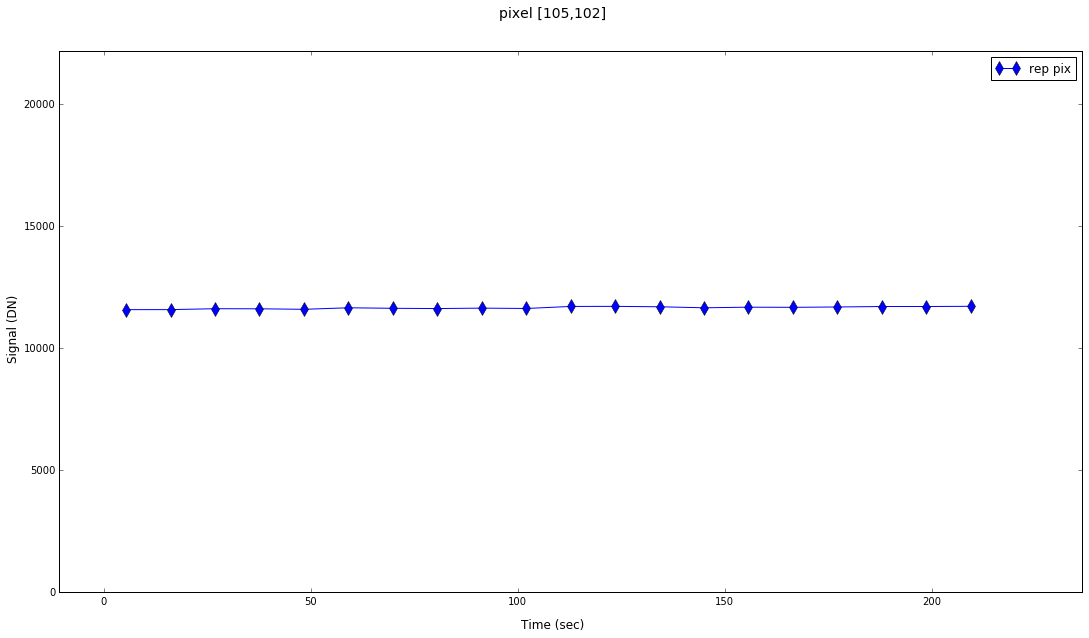

In [17]:
# plot reduced data pixel ramp

f, ax = plt.subplots(1, 1, figsize=(15,8))
ax = plot_pixel(reduced, repx, repy,'rep pix',ax, 'blue',0,mean+10000, 0,ngroups+1, mode)
f.text(0.5, -0.02, 'Time (sec)', ha='center', fontsize=12)
f.text(0.5, 1.04, 'pixel [%s,%s]'% (str(repx),str(repy)), ha='center', fontsize=14)
f.text(-0.005, 0.5, 'Signal (DN)', va='center', rotation='vertical', fontsize=12)
f.tight_layout()


For representative pixel:
IMAGE: 3.17407
ERR: 0.270578


/Users/acanipe/miniconda2/envs/python3/lib/python3.5/site-packages/astropy/stats/sigma_clipping.py:189: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/acanipe/miniconda2/envs/python3/lib/python3.5/site-packages/astropy/stats/sigma_clipping.py:190: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


<module 'matplotlib.pyplot' from '/Users/acanipe/miniconda2/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

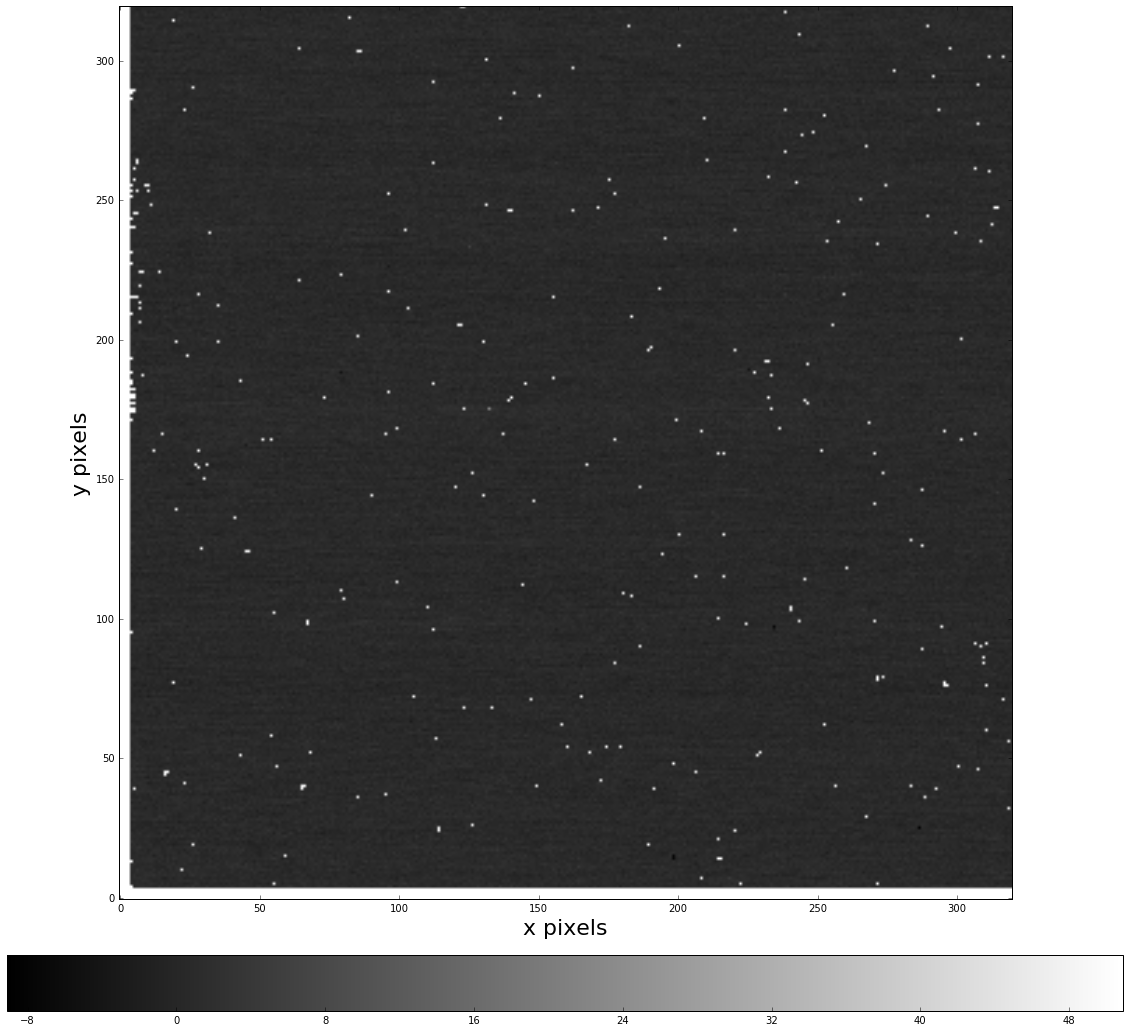

In [14]:
# Look at the slope image

print('\nFor representative pixel:')
print('IMAGE:',slopes[repy,repx])
print('ERR:',err[repy,repx])

# display the rates
# vmin/vmax match ds9 scale limits or the limits of the data
# use sigma_clipped_stats to get mean for rate limits

rate_mean,rate_med,rate_std = sigma_clipped_stats(slopes,sigma=3)
display_img(slopes,rate_mean-10,rate_mean+50)

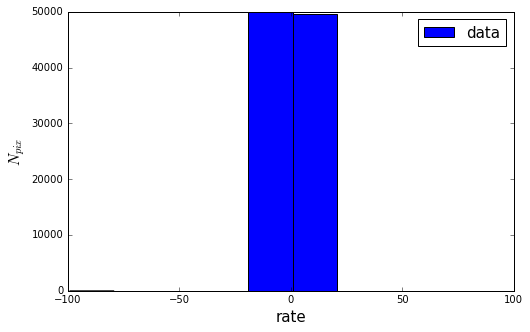

In [15]:
# make a histogram of the values in the first group
plt.figure(figsize=(8, 5))
bin_vals,bins,patches = plt.hist(np.ravel(slopes),bins=np.arange(rate_mean-100,rate_mean+100,20),range=(rate_mean-100,rate_mean+100),label='data')
plt.xlabel('rate',fontsize=15)
plt.ylabel('$N_{pix}$',fontsize=15)
plt.legend(fontsize=15)

## Turning on/off certain pipeline steps

As mentioned before, it is a little tricky to change the calibration steps performed by the pipeline. You need to turn off all the steps that you don't want to perform. As a weird example, if you want to turn off superbias, refpix, and linearity, the command is:

        % ncdhas NRCV82600049001P0000000002102 -dr -ipc -cbs -cl 

Or to give the pipeline a configuration file (for instance, for CV3 test data) and turn on the flat field step with your own PFlat reference file:

        % ncdhas NRCV82600049001P0000000002102 +cfg isimcv3 +cf +FFf /dir/to/file/PFlat.fits

## Input and output images

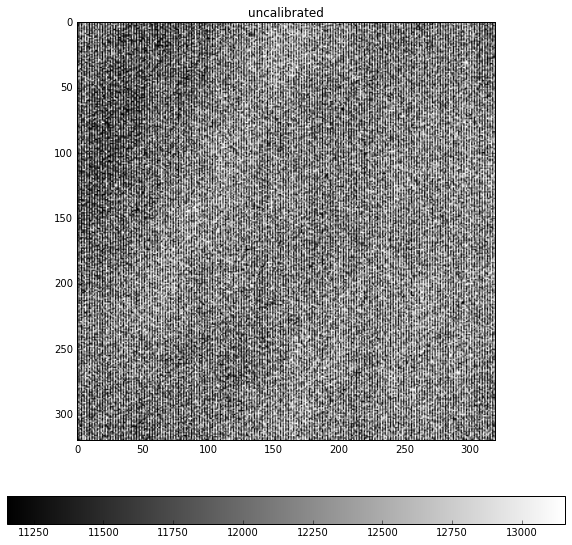

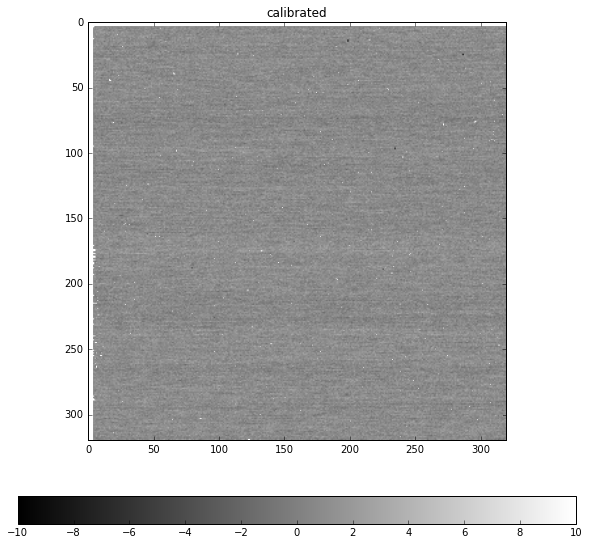

In [22]:
# display images from each step

columns = 1
titles = ['uncalibrated','calibrated']
vmins = [mean-1000,-10]
vmaxs = [mean+1000,10]
images = [imageUncal[0,:,:],slopes]
for i, image in enumerate(images):
    plt.figure(figsize=(10,10))
    plt.imshow(image,vmin=vmins[i],vmax=vmaxs[i], cmap=plt.cm.gray)
    plt.colorbar(orientation='horizontal',pad=0.1) 
    plt.title(titles[i])